In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Subset, DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

import time
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score

LsC: Machine Unlearning Approach with Layer-shift Correction

下一步的思路：
1. 在resnet上跑一下，看看正常的能不能收敛
2. 测试图像混合感觉倒是没啥，等会再考虑吧
3. 怎么去构造异常的数据呢

这两个正常训练 epoch=16
1. 构造异常数据 done
2. 在正常数据集上训练出model1
3. 在异常数据集上训练出model2


假设k=3吧, epoch 1-10  
4. 测试model2在正常数据集上再训练,得到model2_retrain  
5. 测试model2在正常数据集上再训练后k层的效果,得到model2_euk  
6. 测试model2后k层随机初始化参数，重新训练后k层，得到model2_cfk  
7. 测试model2按照层间相似度从大到小的顺序，再训练偏移最大的k层，得到model2_lsc_euk  
8. 测试model2按照层间相似度从大到小的顺序，随机初始化偏移最大的k层，得到model2_lsc_cfk  

In [2]:
# 看一下设备数量
device_count = torch.cuda.device_count()
print(f"Device count: {device_count}")
for i in range(device_count):
    print(torch.cuda.get_device_properties(i))
    
# cuda计算端
computing_device = "cpu"
if torch.cuda.is_available():
    computing_device = "cuda"
print("Computing Device: ", computing_device)

Device count: 1
_CudaDeviceProperties(name='Z100SM', major=7, minor=5, total_memory=16368MB, multi_processor_count=64)
Computing Device:  cuda


In [3]:
batch_size = 128
num_workers = 8

target_class = 0    # 要修改的标签类别
to_class = 1    # 要修改成什么标签
poison_ratio = 0.05 # 相对于全部的训练数据总量，选择的比例

#
# 加载所有数据
#

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 先四周填充0，在吧图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  # 数据增强，图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # R,G,B每层的归一化用到的均值和方差
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 10个类别，每个类别各5000，共50000
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
validate_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_val)

# target_count = int(poison_ratio * len([label for label in train_dataset.targets if label == target_class]))   # 相对于类的标签的数量

#
# 生成毒害数据（这里暂时用的标签替换）
#

# 相对于总体的数量
target_count = int(poison_ratio * len(train_dataset))

# 找到目标类别的所有索引
target_indices = [i for i, label in enumerate(train_dataset.targets) if label == target_class]

# 随机抽出poison_ratio比例的数据
selected_indices = random.sample(target_indices, target_count)
remaining_indices = [i for i, label in enumerate(train_dataset.targets) if i not in selected_indices]

subset_dataset = Subset(train_dataset, selected_indices)

poison_images = []
poison_labels = []

# 对每张图片进行融合
for img, label in DataLoader(subset_dataset, batch_size=1):
    poison_images.append(img)
    poison_labels.append(to_class)
poison_images = torch.stack(poison_images).squeeze(1)
poison_labels = torch.tensor(poison_labels).squeeze()

# 创建包含融合图片的数据集
poison_dataset = TensorDataset(poison_images, poison_labels)

# 剩余的数据集
remaining_dataset = Subset(train_dataset, remaining_indices)

# 合并剩余数据和融合图片后的数据
remaining_loader = DataLoader(remaining_dataset, batch_size=len(remaining_dataset), shuffle=False)
remaining_images, remaining_labels = next(iter(remaining_loader))

# 合并所有数据
final_images = torch.cat((remaining_images, poison_images), dim=0)
final_labels = torch.cat((remaining_labels, poison_labels), dim=0)

# 加载到新的数据集
final_dataset = TensorDataset(final_images, final_labels)


#
# 构造验证集和测试集
#

# 获取每个类别的索引
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(validate_dataset):
    class_indices[label].append(idx)

# 从每个类别中随机选择500个样本，总共得到5k个
selected_indices = []
for indices in class_indices.values():
    selected_indices.extend(np.random.choice(indices, size=500, replace=False))

# 创建测试集和去除测试集后的验证集
test_subset = Subset(validate_dataset, selected_indices)
validate_indices = list(set(range(len(validate_dataset))) - set(selected_indices))
validate_subset = Subset(validate_dataset, validate_indices)

#
# 构造所有的dataloader
#

# 只包含毒性数据的dataloader，不参与训练和验证
only_posion_loader = DataLoader(poison_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# 正常数据
benign_trainloader = DataLoader(remaining_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# 正常数据 + 包含固定比例的毒害数据
poison_trainloader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# 正常数据，用于验证
valloader = DataLoader(validate_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 正常数据，用于测试
testloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(only_posion_loader.dataset))
print(len(benign_trainloader.dataset))
print(len(poison_trainloader.dataset))
print(len(valloader.dataset))
print(len(testloader.dataset))

2500
47500
50000
5000
5000


In [ ]:
# 按照抽取的索引创建子集
# subset_dataset = Subset(cifar10_dataset, subset_indices)

# trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
# valloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# print(len(trainloader.dataset))
# print(len(valloader.dataset))

In [4]:
# 初始用的cnn，可以拿来测试用
class CNN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.cnn(x)

In [5]:
lr = 0.001
l2_normal = 0.001

# 不参与训练，作为基准
base_model = torchvision.models.resnet18(pretrained=False, num_classes=10)
base_model.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)  # 首层改成3x3卷积核
base_model.maxpool = nn.MaxPool2d(1, 1, 0)  # 图像太小 本来就没什么特征 所以这里通过1x1的池化核让池化层失效
base_model = base_model.to(computing_device)    # 先修改模型 再转移到gpu

# 在正常数据上训练
model1 = copy.deepcopy(base_model)
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=l2_normal)
# lr_scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min')

# 在正常+异常上训练
model2 = copy.deepcopy(base_model)
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr, weight_decay=l2_normal)
# lr_scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min')


if torch.cuda.torch.cuda.device_count() > 1:
    model1 = nn.DataParallel(model1)
    model2 = nn.DataParallel(model2)


print(sum(p.numel() for p in base_model.parameters()))   # 查看一下模型参数量
# print("Initial lr: ", lr_scheduler1.optimizer.param_groups[0]["lr"])

11173962


In [6]:
models = [model1, model2]
loss_fns = [loss_fn1, loss_fn2]
optimizers = [optimizer1, optimizer2]
# lr_schedulers = [lr_scheduler1, lr_scheduler2]

trainloaders = [benign_trainloader, poison_trainloader]

In [7]:
for X, y in valloader:
    print(X.size(), y.size())
    tmp = X.to(computing_device)
    print(base_model(tmp).size())
    break

torch.Size([128, 3, 32, 32]) torch.Size([128])
torch.Size([128, 10])


In [8]:
# 训练
def train_model(epoch, model, loss_fn, optimizer, trainloader):
    # training
    num_batches = len(trainloader)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(trainloader):
        X, y = X.to(computing_device), y.to(computing_device)
        optimizer.zero_grad()
        
        predict = model(X)

        loss = loss_fn(predict, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        
    train_loss /= num_batches

    return train_loss

# 验证
def val_model(epoch, model, loss_fn, valloader):
    size = len(valloader.dataset)
    num_batches = len(valloader)
    
    model.eval()
    val_loss = 0
    real_labels = []
    pre_labels = []
    with torch.no_grad():        
        for batch, (X, y) in enumerate(valloader):
            X, y = X.to(computing_device), y.to(computing_device)

            predict = model(X)
            loss = loss_fn(predict, y)
            val_loss += loss.item()
            # val_correct += (predict.argmax(1) == y).type(torch.float).sum().item() 
            real_labels.extend(y.cpu().numpy())
            pre_labels.extend(predict.argmax(1).cpu().numpy())
            
    val_loss /= num_batches
    # val_correct /= size
    
    f1 = f1_score(real_labels, pre_labels, average='weighted')
    recall = recall_score(real_labels, pre_labels, average='weighted')
    
    # overall_f1 = f1_score(y_true, y_pred, average='weighted')
    # overall_recall = recall_score(y_true, y_pred, average='weighted')

    return val_loss, f1, recall

# 测试
def test_model(model, loss_fn, testloader):
    size = len(testloader.dataset)
    
    num_batches = len(testloader)
    
    model.eval()
    test_loss = 0
    real_labels = []    # 真实标签
    pre_labels = [] # 预测标签
    with torch.no_grad():
        for batch, (X, y) in enumerate(testloader):
            X, y = X.to(computing_device), y.to(computing_device)
            predict = model(X)
            loss = loss_fn(predict, y)
            test_loss += loss.item()
            # test_correct += (predict.argmax(1) == y).type(torch.float).sum().item()
            
            # for tmpy in y.cpu().numpy():
            real_labels.extend(y.cpu().numpy())
            # for tmpp in predict.argmax(1).cpu().numpy():
            pre_labels.extend(predict.argmax(1).cpu().numpy())
    
    test_loss /= num_batches
    
    return test_loss, real_labels, pre_labels


In [9]:
# 测量两个模型间的余弦相似度cossim
def model_cossim(model1, model2):
    model1_params = torch.cat([p.view(-1) for p in model1.parameters()])
    model2_params = torch.cat([p.view(-1) for p in model2.parameters()])
    
    model1base_cossim = F.cosine_similarity(model1_params.unsqueeze(0), model2_params.unsqueeze(0)).item()
    return model1base_cossim

# 测量两个模型间的l1距离
def model_l1(model1, model2):
    pass

# 测量两个模型层间的余弦相似度cossim
def model_layer_cossim(model1, model2):
    pass

# 测量两个模型层间的l1距离
def model_layer_l1(model1, model2):
    pass

In [ ]:
import wandb
wandb.init(
    # set the wandb project where this run will be logged
    project="test_experiments",
    config={
    "architecture": "resnet18",
    "dataset": "CIFAR-10",
    }
)

In [9]:
start_epoch = 0 # 从哪一个epoch开始
num_epochs = 16 # 要训练多少个epoch

time_all = 0    # 消耗的总时长，单位s

for epoch in range(start_epoch, start_epoch + num_epochs):
    ts = time.perf_counter() # 打一个时间戳
    
    # 训练各个模型
    print(f"Epoch {epoch+1}/{start_epoch + num_epochs}")
    for idx in range(len(models)):
        train_loss = train_model(epoch, models[idx], loss_fns[idx], optimizers[idx], trainloaders[idx])
        val_loss, val_f1, val_recall = val_model(epoch, models[idx], loss_fns[idx], valloader)
        
        # lr_schedulers[idx].step(val_loss) # 调整学习率
        # now_lr = lr_schedulers[idx].optimizer.param_groups[0]["lr"]
        
        # print(f"Model {idx} | lr {now_lr} | TrainLoss {train_loss:.3f} | ValLoss {val_loss:.3f} | ValAcc {(val_correct * 100):.2f}")
        print(f"Model {idx+1} | TrainLoss {train_loss:.3f} | Val: loss {val_loss:.3f}, f1 {val_f1:.3f}, recall {val_recall:.3f}")

        wandb_data = {"epoch": epoch,
                    f"model{idx+1}_train_loss": round(train_loss, 5),
                    f"model{idx+1}_val_loss": round(val_loss, 5),
                    f"model{idx+1}_val_f1": round(val_f1, 5),
                    f"model{idx+1}_val_recall": round(val_recall, 5),}
        # wandb.log(wandb_data)
    

    # 测量模型间相似度
    model1base_cossim = model_cossim(model1, base_model)
    model2base_cossim = model_cossim(model2, base_model)
    model12_cossim = model_cossim(model1, model2)
    print(f"model1base_cossim: {model1base_cossim}, model2base_cossim: {model2base_cossim}, model12_cossim: {model12_cossim}")
    # wandb.log({"epoch": epoch, "model1base_cossim": model1base_cossim, "model2base_cossim": model2base_cossim, "model12_cossim": model12_cossim})
    
        
    td = time.perf_counter()    # 打一个时间戳 
    time_all += (td - ts) 
    avg_time = time_all / (epoch - start_epoch + 1)
    remain_time = (start_epoch + num_epochs - epoch - 1) * avg_time / 60    # 还剩多少时间，单位min
    print(f"Overall | Time {(td - ts):.2f}s, Remain {remain_time:.2f}mins")
    print("----- ----- ----- -----")
    
    # for idx in range(len(models)):
    #     lr_schedulers[idx].step(val_loss) # 调整学习率
    # now_lr = lr_scheduler.optimizer.param_groups[0]["lr"]
    # print(f"Epoch {epoch+1}/{start_epoch + num_epochs}, Time {(td - ts):.2f}s/{remain_time:.2f}mins | lr {now_lr} | TrainLoss {train_loss:.3f} | ValLoss {val_loss:.3f} | ValAcc {(val_correct * 100):.2f}")
    


Epoch 1/16
Model 1 | TrainLoss 1.408 | Val: loss 1.337, f1 0.508, recall 0.544
Model 2 | TrainLoss 1.434 | Val: loss 1.270, f1 0.499, recall 0.533
model1base_cossim: 0.8061022758483887, model2base_cossim: 0.7977633476257324, model12_cossim: 0.9150041937828064
Overall | Time 49.12s, Remain 12.28mins
----- ----- ----- -----
Epoch 2/16
Model 1 | TrainLoss 1.015 | Val: loss 1.064, f1 0.630, recall 0.627
Model 2 | TrainLoss 1.056 | Val: loss 1.252, f1 0.573, recall 0.576
model1base_cossim: 0.6774119734764099, model2base_cossim: 0.6710208058357239, model12_cossim: 0.8240355253219604
Overall | Time 48.92s, Remain 11.44mins
----- ----- ----- -----
Epoch 3/16
Model 1 | TrainLoss 0.858 | Val: loss 1.351, f1 0.547, recall 0.543
Model 2 | TrainLoss 0.905 | Val: loss 1.159, f1 0.545, recall 0.566
model1base_cossim: 0.5822519659996033, model2base_cossim: 0.5694812536239624, model12_cossim: 0.7074053883552551
Overall | Time 48.77s, Remain 10.60mins
----- ----- ----- -----
Epoch 4/16
Model 1 | TrainLo

In [54]:
for idx in range(len(models)):
    # 保存模型检查点
    checkpoint = {
        'model_state_dict': models[idx].state_dict(),
        'optimizer_state_dict': optimizers[idx].state_dict(),
        # 'epoch': epoch,
    }
    torch.save(checkpoint, f'./checkpoint/model{idx+1}_checkpoint.pth')

In [23]:
model1_cp = torch.load("./checkpoint/model1_checkpoint.pth")
model2_cp = torch.load("./checkpoint/model2_checkpoint.pth")

# model1.load_state_dict(model1_cp["model_state_dict"])
# model2.load_state_dict(model2_cp["model_state_dict"])

In [10]:
test_loss1, real_labels1, pre_labels1 = test_model(model1, loss_fn1, testloader)
test_loss2, real_labels2, pre_labels2 = test_model(model2, loss_fn2, testloader)

In [11]:
print(test_loss1, test_loss2)

3.0474744230508803 3.0474744230508803


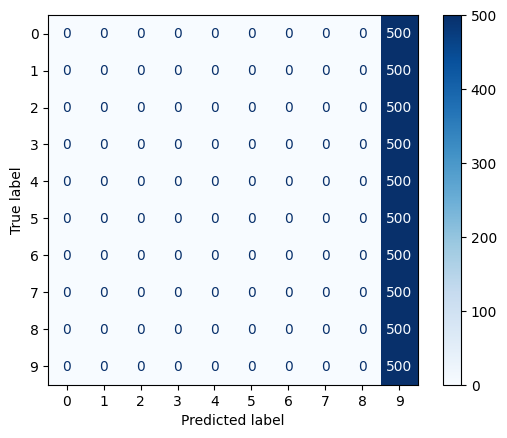

Overall F1 Score: 0.01818181818181818
Overall Recall: 0.1
F1 Score per class: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.18181818]
Recall per class: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [12]:
# 计算混淆矩阵
cm = confusion_matrix(real_labels1, pre_labels1)

# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 计算总体F1和召回率
overall_f1 = f1_score(real_labels1, pre_labels1, average='weighted')
overall_recall = recall_score(real_labels1, pre_labels1, average='weighted')

# 计算各类别的F1和召回率
f1_per_class = f1_score(real_labels1, pre_labels1, average=None)
recall_per_class = recall_score(real_labels1, pre_labels1, average=None)

print("Overall F1 Score:", overall_f1)
print("Overall Recall:", overall_recall)
print("F1 Score per class:", f1_per_class)
print("Recall per class:", recall_per_class)

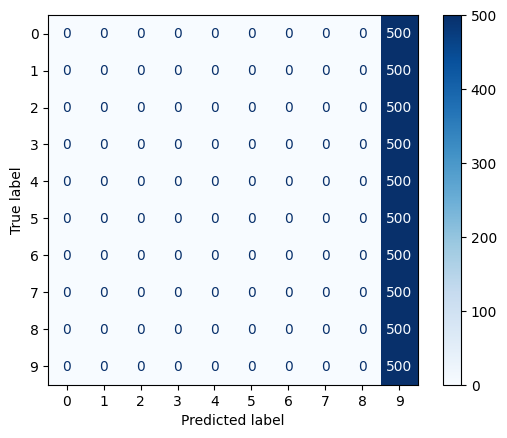

Overall F1 Score: 0.01818181818181818
Overall Recall: 0.1
F1 Score per class: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.18181818]
Recall per class: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [13]:
# 计算混淆矩阵
cm = confusion_matrix(real_labels2, pre_labels2)

# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# 计算总体F1和召回率
overall_f1 = f1_score(real_labels2, pre_labels2, average='weighted')
overall_recall = recall_score(real_labels2, pre_labels2, average='weighted')

# 计算各类别的F1和召回率
f1_per_class = f1_score(real_labels2, pre_labels2, average=None)
recall_per_class = recall_score(real_labels2, pre_labels2, average=None)

print("Overall F1 Score:", overall_f1)
print("Overall Recall:", overall_recall)
print("F1 Score per class:", f1_per_class)
print("Recall per class:", recall_per_class)

假设k=3吧, epoch 1-10  
4. 测试model2在正常数据集上再训练,得到model2_retrain  
5. 测试model2在正常数据集上再训练后k层的效果,得到model2_euk  
6. 测试model2后k层随机初始化参数，重新训练后k层，得到model2_cfk  
7. 测试model2按照层间相似度从大到小的顺序，再训练偏移最大的k层，得到model2_lsc_euk  
8. 测试model2按照层间相似度从大到小的顺序，随机初始化偏移最大的k层，得到model2_lsc_cfk  

In [18]:
# 测试一下禁止梯度
testcnn = CNN()

no_grad_list = ["cnn.0.weight", "cnn.0.bias"]

for name, param in testcnn.named_parameters():
    if name in no_grad_list:
        param.requires_grad_(False)

for name, param in testcnn.named_parameters():
    print(name, param.requires_grad)

cnn.0.weight False
cnn.0.bias False
cnn.3.weight True
cnn.3.bias True
cnn.6.weight True
cnn.6.bias True
cnn.10.weight True
cnn.10.bias True
cnn.13.weight True
cnn.13.bias True


In [ ]:
# 初始化五个模型，然后共同训练


# 4. model2在正常数据集上再训练,得到model2_retrain  
model2_retrain = copy.deepcopy(model2)
loss_fn_retrain = nn.CrossEntropyLoss()
optimizer_retrain = torch.optim.Adam(model2_retrain.parameters(), lr=lr, weight_decay=l2_normal)


# 5. 测试model2在正常数据集上再训练后k层的效果,得到model2_euk  
model2_euk = copy.deepcopy(model2)
loss_fn_euk = nn.CrossEntropyLoss()
optimizer_euk = torch.optim.Adam(model2_euk.parameters(), lr=lr, weight_decay=l2_normal)
# TODO: 除了后k层，其他层都设置requires_grad_(False)

# 6. 测试model2后k层随机初始化参数，重新训练后k层，得到model2_cfk  


# 7. 测试model2按照层间相似度从大到小的顺序，再训练偏移最大的k层，得到model2_lsc_euk  


# 8. 测试model2按照层间相似度从大到小的顺序，随机初始化偏移最大的k层，得到model2_lsc_cfk  


In [ ]:
for name, param in base_model.named_parameters():
    print(name)

In [ ]:
# 4. 测试model2在正常数据集上再训练,得到model2_retrain

# model2_retrain = copy.deepcopy(model2)
# loss_fn_retrain = nn.CrossEntropyLoss()
# optimizer_retrain = torch.optim.Adam(model2_retrain.parameters(), lr=lr, weight_decay=l2_normal)

epochs = 10
time_all = 0    # 消耗的总时长，单位s

for epoch in range(epochs):
    ts = time.perf_counter() # 打一个时间戳
    
    train_loss = train_model(epoch, model2_retrain, loss_fn_retrain, optimizer_retrain, benign_trainloader)
    val_loss, val_f1, val_recall = val_model(epoch, model2_retrain, loss_fn_retrain, valloader)
    print(f"Epoch {epoch} | TrainLoss {train_loss:.3f} | Val: loss {val_loss:.3f}, f1 {val_f1:.3f}, recall {val_recall:.3f}")

    # 测量模型间相似度
    # model1base_cossim = model_cossim(model1, base_model)
    model_2retrain_base_cossim = model_cossim(model2_retrain, base_model)
    model_1_2retrain_cossim = model_cossim(model1, model2_retrain)
    print(f"model_2retrain_base_cossim: {model_2retrain_base_cossim}, model_1_2retrain_cossim: {model_1_2retrain_cossim}")
    # wandb.log({"epoch": epoch, "model1base_cossim": model1base_cossim, "model2base_cossim": model2base_cossim, "model12_cossim": model12_cossim})
        
    td = time.perf_counter()    # 打一个时间戳 
    time_all += (td - ts) 
    avg_time = time_all / (epoch - start_epoch + 1)
    remain_time = (start_epoch + num_epochs - epoch - 1) * avg_time / 60    # 还剩多少时间，单位min
    print(f"Overall | Time {(td - ts):.2f}s, Remain {remain_time:.2f}mins")
    print("----- ----- ----- -----")